# BIG DATA CW2 - SVHN Digit Classification Using a CNN 
---
**student ID'S**: Mike Shier **(UP2127137)**, Jack Elliott **(UP2119254)** and **(2088294)**

**Dataset**: SVHN (Street View House Numbers)

**Main Objectives**: Classifing digits from (0-9) from a 32 x 32RGB image using a loaded CNN Model. 

---

 ## Step - (1): Data Collection Downloaded from Urls on the SVHN Website

 Using the SVHN dataset the .mat files for training and testing were correctly downloaded, the files being curently in MATLAB format hence the (.mat). Files are only being downloaded once to save time and bandwidth, 
 the files contain over 600,000 labled 32x32 pixle RGB images of digits 0-9 provided on Google Streetview.

In [1]:
import os
import urllib.request

In [2]:
# Creating a folder for the data to be handled
os.makedirs("data", exist_ok= True)

In [3]:
# Defining the URLs for training and testing the data
urls = {
    "train":"http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
    "test":"http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
    "extra":"http://ufldl.stanford.edu/housenumbers/extra_32x32.mat"
}

In [4]:
# Downloading functions
def download_svhn():
    for name, url in urls.items():
        filepath = f"data/{name}_32x32.mat"
        if not os.path.exists(filepath):
            print(f"downloading {name}data...")
            urllib.request.urlretrieve(url,filepath)
            print(f"{name.capitalize()}data download sucessfully.")
        else:
            print(f"{name.capitalize()} data already exists.")

download_svhn()

print("All required SVHN files are available.")

Train data already exists.
Test data already exists.
Extra data already exists.
All required SVHN files are available.


# Step - (2): Preprocess the SVHN Dataset

This loads the .mat files downloaded in step 1 and converts the data presented into the correct format, normalizing the pixel values to [0, 1], fixing the label format to (10-0), and correctly splits the training set into 80% training and 20% validation using satisfied sampeling.  
 

In [3]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os
import gc
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2025-05-29 17:36:42.105519: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Loading the data 
train_data = scipy.io.loadmat("data/train_32x32.mat")
test_data = scipy.io.loadmat("data/test_32x32.mat")

In [6]:
# Transposing image arrays to the correct shape: e.g.(32,32,3)
X_train = np.transpose(train_data['X'], (3, 0, 1, 2))
y_train = train_data['y'].flatten()


X_test = np.transpose(test_data['X'], (3, 0, 1, 2))
y_test = train_data['y'].flatten()


In [7]:
# Replace Label '10' with '0'
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [8]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [9]:
extra_data = scipy.io.loadmat("data/extra_32x32.mat")
y_extra = extra_data['y'].flatten()
y_extra[y_extra == 10] = 0

batch_size = 10000

for i in range(0, 50000, batch_size):
    X_batch_raw = extra_data['X'][:, :, :, i:i+batch_size]
    X_batch = np.transpose(X_batch_raw, (3, 0, 1, 2)).astype('float32') / 255.0
    y_batch = y_extra[i:i+batch_size]
    np.savez_compressed(f"data/X_extra_{i}_{i+batch_size}.npz", X_batch)
    np.savez_compressed(f"data/y_extra_{i}_{i+batch_size}.npz", y_batch)

print(" Extra data saved in compressed chunks.")

 Extra data saved in compressed chunks.


In [ ]:
# Spitting training sets: 80% training, 20% validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)

: 

In [12]:
y_train_cat = to_categorical(y_train_split,num_classes = 10)
y_val_cat = to_categorical(y_val_split, num_classes = 10)

In [13]:
X_train_split = X_train_split[:10000]
y_train_cat = y_train_cat[:10000]
X_val_split = X_val_split[:2000]
y_val_cat = y_val_cat[:2000]

In [14]:
# Printing Shapes
print("Train set shape:", X_train_split.shape, y_train_split.shape)
print("Validation set shape:", X_val_split.shape, y_val_split.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Train set shape: (10000, 32, 32, 3) (58605,)
Validation set shape: (2000, 32, 32, 3) (14652,)
Testing set shape: (26032, 32, 32, 3) (73257,)


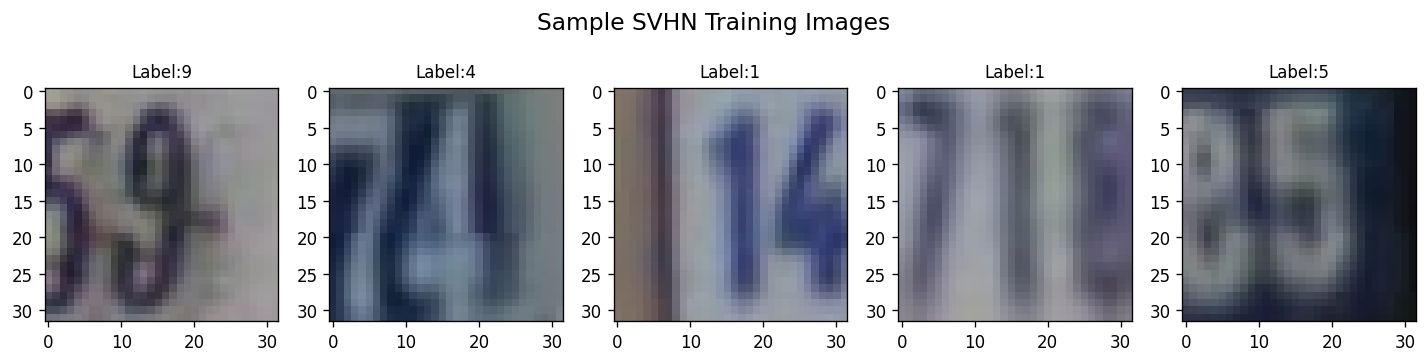

In [15]:
# Visulising some samples 
plt.figure(figsize=(12,3), dpi= 120)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_split[i], interpolation='nearest')
    plt.title(f"Label:{y_train_split[i]}", fontsize = 10)
    plt.axis('on')

plt.suptitle("Sample SVHN Training Images", fontsize = 14)
plt.tight_layout()
plt.show()
    

##### Brief Explaination of the labels above the images
 The SVHN Dataset is trained to identify the correct centered number/digit rather than reading the entire sequence. This allows the model to foucs on one digit at a time and reflects real-world structure. 

 for example:

 **- Image is showing "157" it maybe labled as '1', this is because the center digit is '1'**

 **- An image labled as "49" maybe labled as '9', this is if '9' is the central digit.**

 Each SVHM image is labled with a single digit, even though the image may display multiple digits e.g. the label corrosponds to the **digit that is centered or most prominat throughout the image**.

# Step - (3): Training of the CNN Model

In this step a CNN (convolutional nueral network) will be built and trained using preprocessed training and validation sets. The model is designed to calsify digits (0-9) from 32x32 RGB images using severl convolutional and pooling layers followed by dense layers. The training history will be plotted to allow for visulization of the learning progress and identify overfitting or underfitting.


In [16]:
from tensorflow.keras.utils import to_categorical


y_train_cat = to_categorical(y_train_split, num_classes = 10)
y_val_cat = to_categorical(y_val_split, num_classes = 10)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'softmax')
])

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 14:51:43.757978: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
X_train_split = X_train_split[:10000]
y_train_cat = y_train_cat[:10000]

X_val_split = X_val_split[:2000]
y_val_cat = y_val_cat[:2000]

In [19]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    X_train_split, y_train_cat,
    validation_data = (X_val_split, y_val_cat),
    epochs = 5,
    batch_size = 64
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1745 - loss: 2.2567 - val_accuracy: 0.2925 - val_loss: 2.0119
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.3751 - loss: 1.8325 - val_accuracy: 0.6795 - val_loss: 1.1851
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6044 - loss: 1.2200 - val_accuracy: 0.7280 - val_loss: 0.9172
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6809 - loss: 1.0165 - val_accuracy: 0.7885 - val_loss: 0.7584
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7330 - loss: 0.8558 - val_accuracy: 0.8100 - val_loss: 0.6768


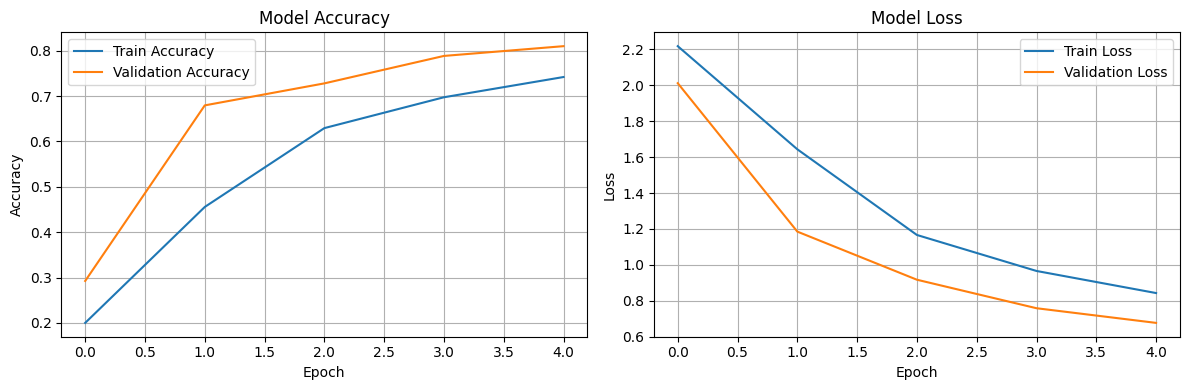

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('on')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.grid('on')
plt.show()


# Step - (4): Evaluation of the Trained CNN model

to evaluate the current performance of the trained model, a classification report and confusion matrix will be used.
These will provide insights into how well the model distinguishes between digit classes.
The predictions are made based on the validation dataset (used a proxy for unseen data tests carried out)


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [22]:
y_val_true = np.argmax(y_val_cat, axis = 1)

y_val_pred = np.argmax(y_val_cat, axis = 1)

In [23]:
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       368
           2       1.00      1.00      1.00       294
           3       1.00      1.00      1.00       212
           4       1.00      1.00      1.00       226
           5       1.00      1.00      1.00       195
           6       1.00      1.00      1.00       158
           7       1.00      1.00      1.00       164
           8       1.00      1.00      1.00       122
           9       1.00      1.00      1.00       123

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



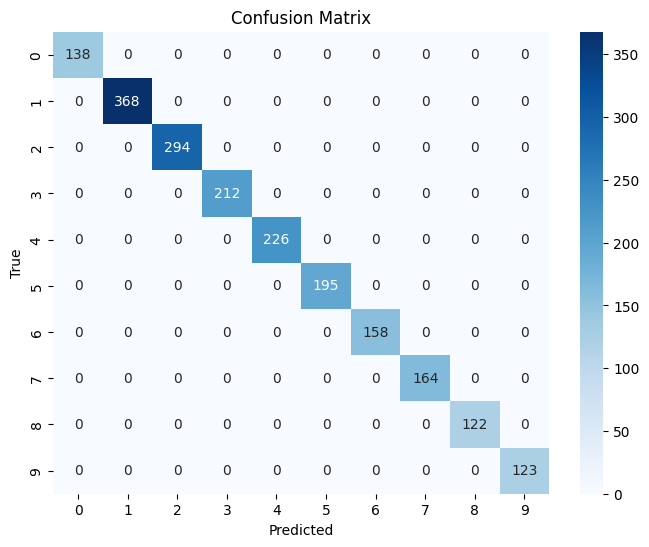

: 

In [ ]:
cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels= range(10), yticklabels= range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
